# Install Dependencies

In [1]:
!pip install gym_anytrading

     |████████████████████████████████| 171 kB 6.9 MB/s eta 0:00:01


### Imports

In [5]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

### Create Env

# Load and Review Dataset

In [ ]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

In [15]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100
2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100
2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900
2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500
2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900


In [16]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-16,1241.989990,1243.699951,1219.630005,1224.060059,1224.060059,1608800
2018-08-17,1222.040039,1226.949951,1204.000000,1215.849976,1215.849976,1654600
2018-08-20,1220.660034,1225.910034,1208.699951,1221.949951,1221.949951,1110900
2018-08-21,1223.020020,1232.760010,1215.030029,1217.410034,1217.410034,1154100
2018-08-22,1214.219971,1226.530029,1213.219971,1221.750000,1221.750000,1114800
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000
2018-08-28,1255.900024,1256.560059,1242.969971,1245.859985,1245.859985,1366500


In [33]:
len(df)

2335

# Register the stock trading environment

In [45]:
window_size = 10
start_index = window_size
end_index = len(df)

env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

The stock trading environment is a good example of a custom environment. A custom environment follows the OpenAI gym interface and at minimum needs to provide these methods:

- `__init__()`: initializes the instance of the environment. The most important thing this method does is define the action space and the observation space.
- `reset()`: resets the state of the environment and returns the initial observation.
- `step(action)`: executes the specified action in the environment, returning the observation that results along with the immediate reward, a flag indicating if the episode is ended and additional information specific to the scenario.

Let's explore some fo the highlights of the stocks-v0 environment. Make sure to follow the inline links to see the code being described in the source repo.

## The base environment class

The `gym_anytrading` library provides the `TradingEnv` base class that represents the general case for any form of trading environment. 

It takes the simplest approach of defining the [Actions](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L9) that an agent can select from as simply either `Sell` or `Buy`. 





## Environment Initialization

In the `__init__` method of the `TradingEnv` class it defines the [action space](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L36) as a discrete action space (e.g., the values are either 0 for sell or 1 for buy). It also defines the [observation space](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L37) as continous, as a `Box` (e.g., the real values range between negative infinity and positive infinity).

In other words, in this environment the agent has discrete options to buy or sell. The observation the environment returns after performing the action reflect the next price of the asset at the next tick in time of the dataset.  

## Environment Reset

The [reset](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L58) method does what you would expect, it resets the state of the environment (e.g., set the accumulated reward to 0, set the tick counter back to the start) and returns an observation that is basically the first price from the history of price data of the asset being traded.



## Environment Step

The [step](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L71) method is where the action the agent selected affects the state of the environment. In the TradingBase class this involves addressing the following:

- _Are we done?_ Compute if the action resulted in the episode being over by [setting the done flag](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L75). In this case, the episode is over when we have reached the last tick in the range of ticks provided. 
- _What reward did the agent earn?_ The [immediate reward that results](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L78) from the taking the action the agent requested is calculated. In the base class, this is just a stub function that is specialized by derived classes, such as that stock trading class we will cover shortly. 
- _Update environment internal state._ In this case the environment [updates its running total of the rewards earned](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L79), the [profit so far](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L81), and if a trade took place [toggling its position from a Short to a Long](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L89) or vice-versa.
- Return the [observation, immediate reward, done flag and any additional metadata](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py#L101) that the environment can communicate to the agent.

# The stocks-v0 environment

The `stocks-v0` environment we loaded previously is represented by the [StocksEnv class](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/stocks_env.py#L6) which derives from the TradingEnv class.

In the [init of the environment](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/stocks_env.py#L8), it configures a default fee amount for bid and ask trades. These fees are expressed in terms of units (e.g., a bid fee is 1% of one share).

The [immediate reward is calculated](https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/stocks_env.py#L41) if a trade took place. It earns a reward that is the difference in price between the current price and when the agent last made a trade. The reward provided to the agent does not incorporate buy or sell fees.

The reward is calculated as follows:
- Positive reward: An agent earns a positive reward when it sells a stock at a higher price than what it had bought it at previously. 
- Negative reward: It might earn a negative reward if it sold below the price at which it bought. 
- Zero reward: If the agent did not make a trade, or if the trade placed was to buy the stock. In other words, the agent only gets a reward when it sells something it had previously bought.

# Train the trading agent

In [54]:
policy_kwargs = dict(net_arch=[dict(vf=[128, 128, 128], pi=[64, 64])])
model = A2C('MlpPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 919      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.686   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -4.44    |
|    value_loss         | 43       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 926      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.674   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates    

# Evaluate the agent

In [55]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    #env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 643.1392199999981, 'total_profit': 0.0004510369080622917, 'position': 1}


## Plot Results

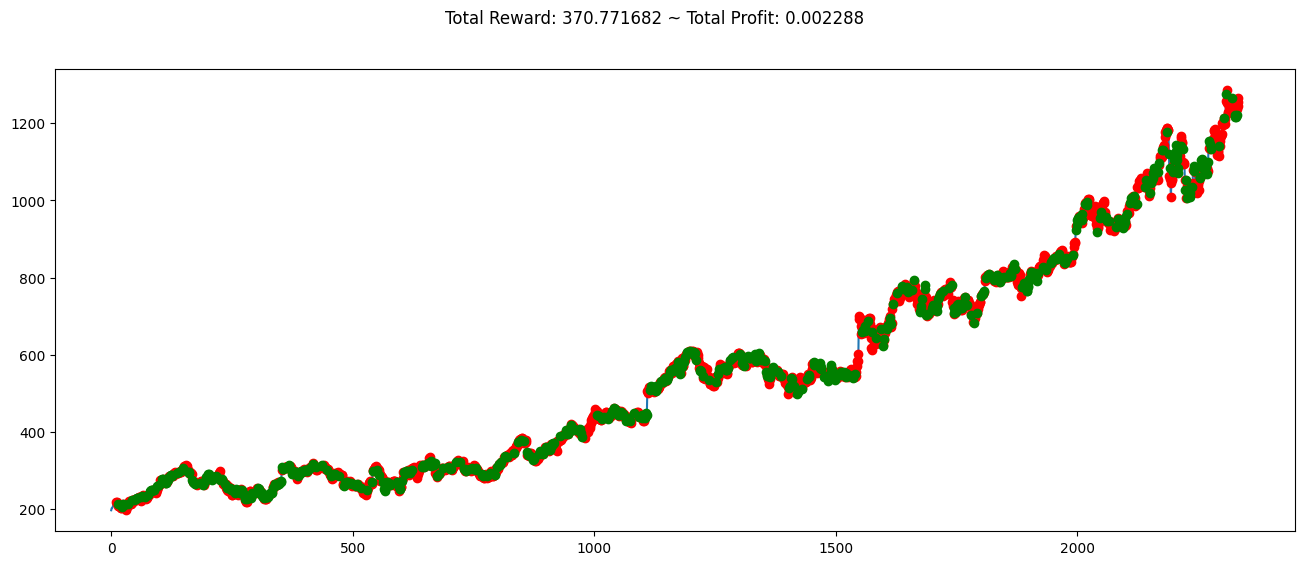

In [49]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

## Examine the quantative results

In [50]:
!pip install quantstats --upgrade --no-cache-dir

     |████████████████████████████████| 41 kB 4.8 MB/s eta 0:00:011
     |████████████████████████████████| 6.9 MB 13.7 MB/s eta 0:00:01


                           Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -99.95%
CAGR﹪                     -56.62%

Sharpe                     -4.08
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -3.82
Sortino                    -4.51
Smart Sortino              -4.22
Sortino/√2                 -3.19
Smart Sortino/√2           -2.99
Omega                      0.19

Max Drawdown               -99.96%
Longest DD Days            3365
Volatility (ann.)          19.96%
Calmar                     -0.57
Skew                       -0.63
Kurtosis                   30.22

Expected Daily %           -0.33%
Expected Monthly %         -6.71%
Expected Yearly %          -53.72%
Kelly Criterion            -87.59%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.39%
Expected Shortfall (cVaR)  -2.39%

Max Consecu

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-06-12,2018-08-17,2018-08-29,3365,-99.95512,-99.949974


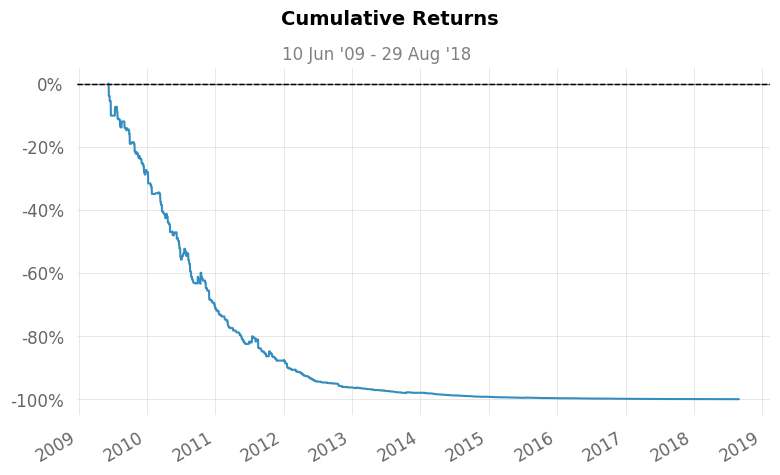

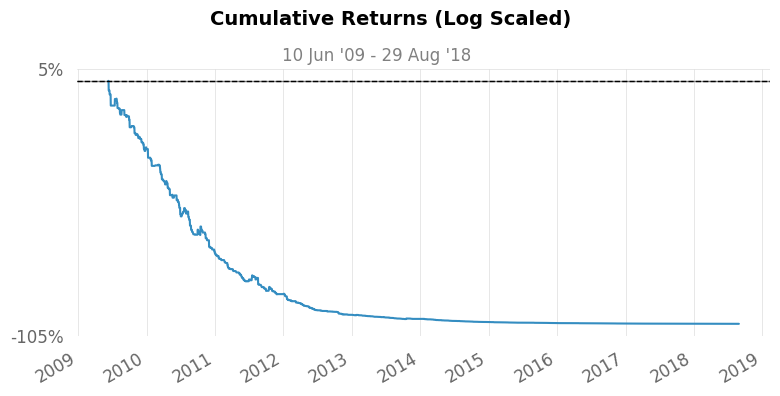

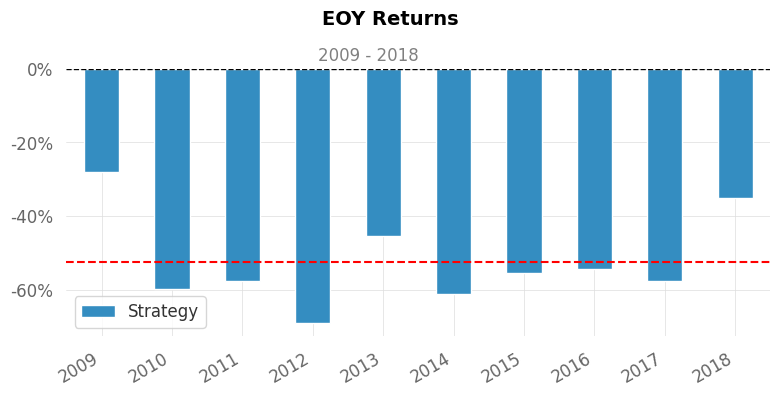

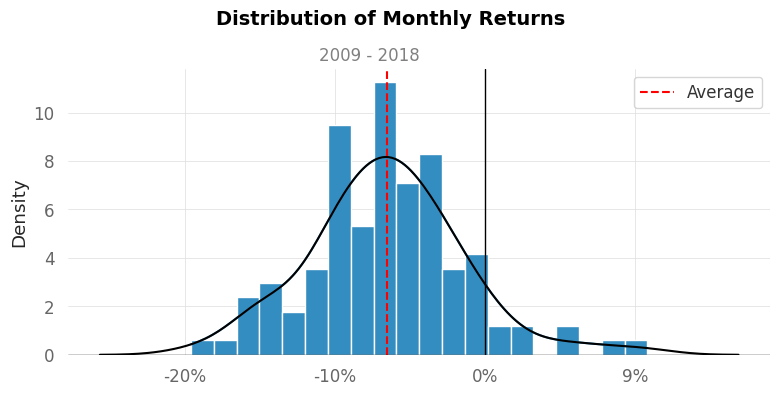

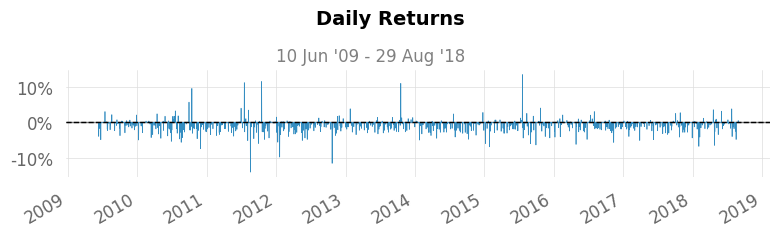

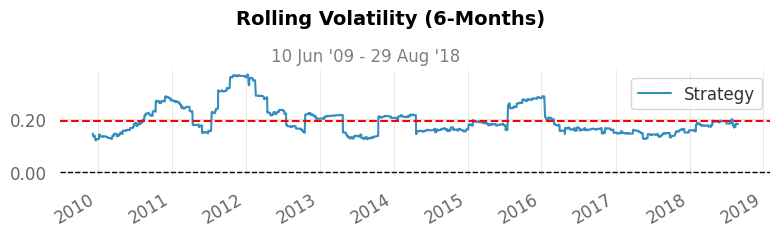

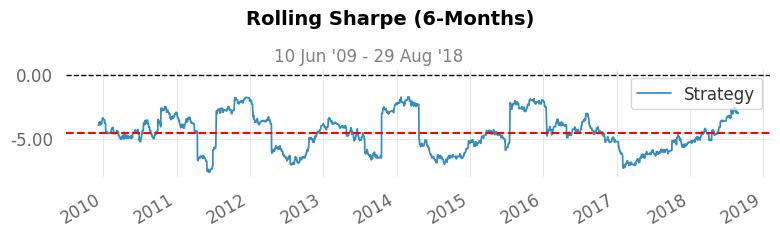

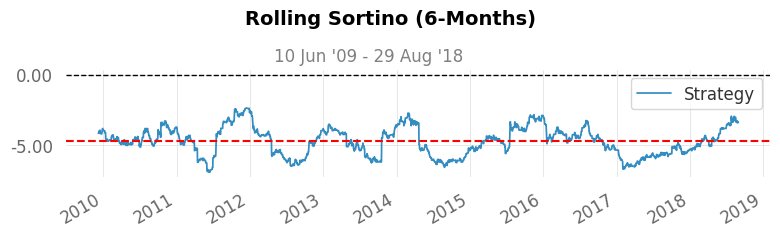

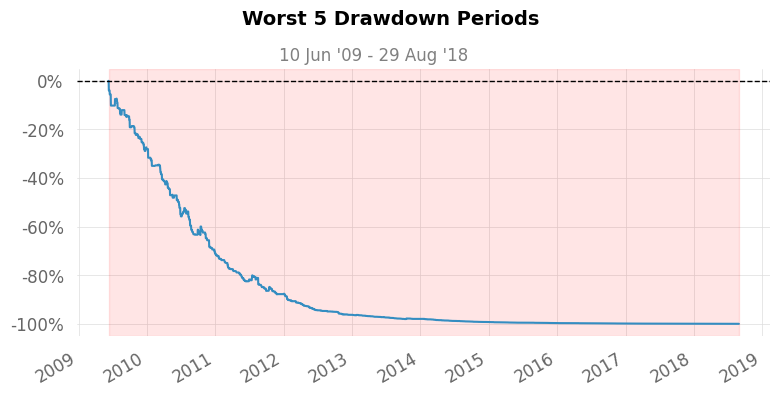

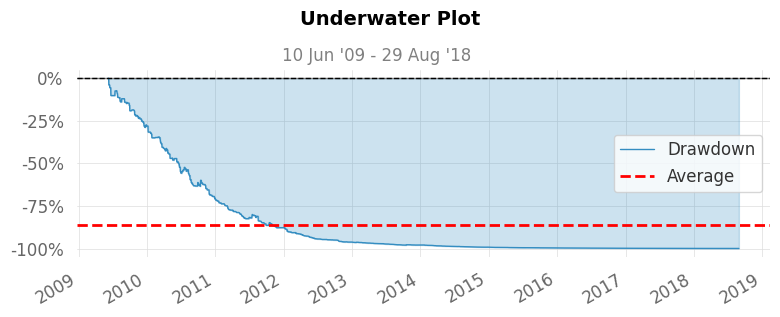

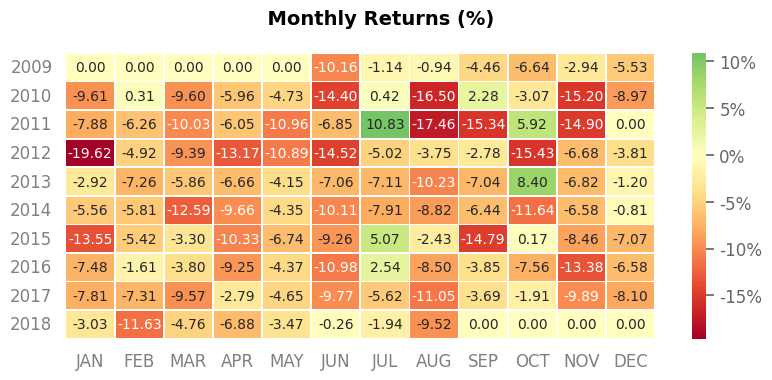

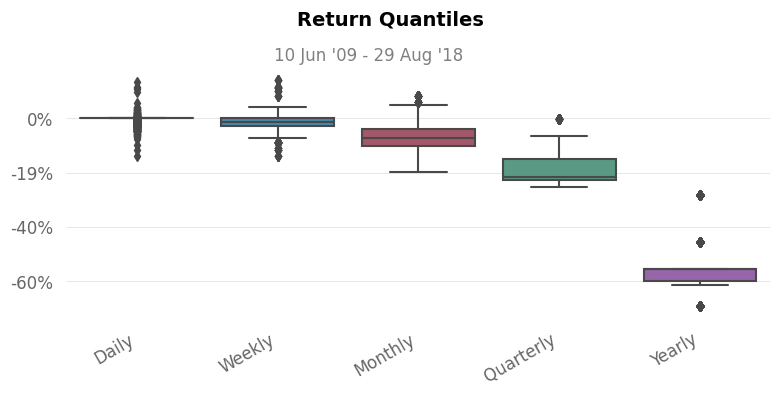

In [56]:
import quantstats as qs
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')

So it's not a great agent (there are lot of things that you could do to improve its performance), but that was not the point- the goal was to learn how to build an environment for a novel scenario.